Controle clássico para um Guindaste Hidráulico Florestal

In [27]:
# Operações com matrizes e vetores:
import numpy as np
import sympy as sp
import control as co_general
import control.matlab as co
import matplotlib.pyplot as plt

 - Declaração das FTs que serão usadas

In [28]:
# Simbolos utilizados:
s = co.tf('s');

In [29]:
# Função de transferência do sistema em malha aberta:
dem = (s + 1)*(s + 2)*(s + 3)*(s + 4)*(s + 5)*(s + 6)
num = 1
G = num/dem
 
print(G)


                            1
----------------------------------------------------------
s^6 + 21 s^5 + 175 s^4 + 735 s^3 + 1624 s^2 + 1764 s + 720



- Identificando os polos do sistema em malha aberta

[-6.+0.j -5.+0.j -4.+0.j -3.+0.j -2.+0.j -1.+0.j]
[]


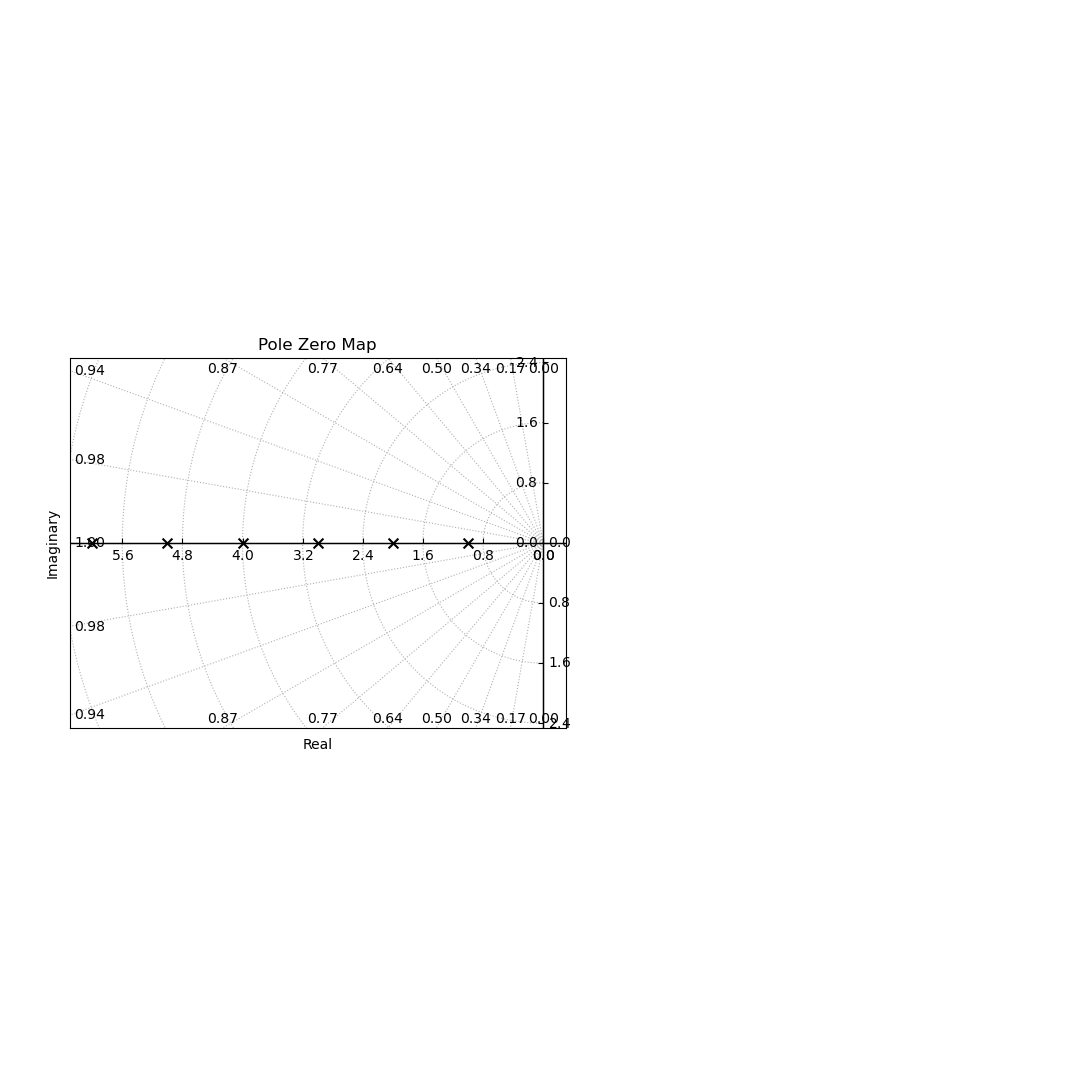

In [30]:
polos = co.pole(G)
zeros = co.zero(G)
co.pzmap(G, plot=True, grid=True, title='Pole Zero Map')


print(polos)
print(zeros)

- Calcula a estabilidade do sistema em malha aberta

In [31]:
# Verificando as condições de Routh-Hurwitz
condicoes_estabilidade = np.all(np.real(polos) < 0)

if condicoes_estabilidade:
    print("O sistema é estável pelo critério de Routh-Hurwitz.")
else:
    print("O sistema é instável pelo critério de Routh-Hurwitz.")

O sistema é estável pelo critério de Routh-Hurwitz.


(array([1.37860757e-03, 1.37846546e-03, 1.37832139e-03, 1.37817535e-03,
        1.37802731e-03, 1.37787724e-03, 1.37772511e-03, 1.37757090e-03,
        1.37741458e-03, 1.37725611e-03, 1.37709547e-03, 1.37693264e-03,
        1.37676757e-03, 1.37660025e-03, 1.37643063e-03, 1.37625870e-03,
        1.37608442e-03, 1.37590775e-03, 1.37572867e-03, 1.37554714e-03,
        1.37536313e-03, 1.37517661e-03, 1.37498754e-03, 1.37479589e-03,
        1.37460163e-03, 1.37440471e-03, 1.37420512e-03, 1.37400279e-03,
        1.37379772e-03, 1.37358984e-03, 1.37337914e-03, 1.37316557e-03,
        1.37294909e-03, 1.37272966e-03, 1.37250725e-03, 1.37228181e-03,
        1.37205331e-03, 1.37182170e-03, 1.37158694e-03, 1.37134900e-03,
        1.37110783e-03, 1.37086338e-03, 1.37061562e-03, 1.37036449e-03,
        1.37010996e-03, 1.36985199e-03, 1.36959051e-03, 1.36932550e-03,
        1.36905689e-03, 1.36878466e-03, 1.36850874e-03, 1.36822909e-03,
        1.36794566e-03, 1.36765840e-03, 1.36736726e-03, 1.367072

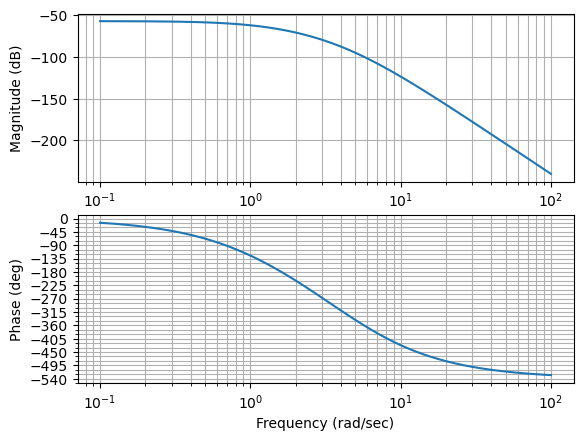

In [32]:
co.bode(G)

(array([ 1.38888889e-03,  1.38888867e-03,  1.38888802e-03, ...,
        -1.14799258e-18, -1.07130174e-18, -9.99734023e-19]),
 array([ 0.00000000e+00, -6.94444389e-07, -1.38888845e-06, ...,
        -2.46735740e-20, -2.27613666e-20, -2.09973542e-20]),
 array([0.00000000e+00, 2.04081633e-04, 4.08163265e-04, ...,
        9.77214697e+02, 9.88541702e+02, 1.00000000e+03]))

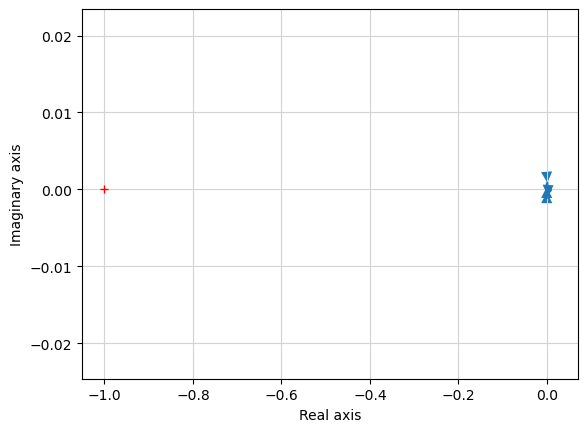

In [33]:
co.nyquist(G)

- Resposta do sistema em malha aberta a uma entrada degrau

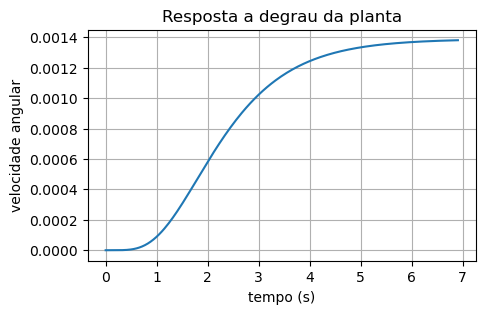

In [34]:
# Resposta a degrau da planta
plt.figure(2, figsize=(5,3))
omegao, t = co.step(G)
plt.plot(t,omegao)
plt.title('Resposta a degrau da planta')
plt.xlabel('tempo (s)')
plt.ylabel('velocidade angular')
plt.grid()